# Model Finalization

Nicholas Imperius 0645031\
Jimmy Tsang 1098204


# Initialization

**Mounting Google Drive, Importing Libraries, Load Data**

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import math
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
# load measures_v2.csv dataset
measures_df = pd.read_csv('/content/drive/MyDrive/ESOF-3675/Project/measures_v2.csv')

#Data Preprocessing

## Synthetic Attribute Derivation

Generate additional features to obtain better results

In [ ]:
#Voltage Magnitude
U = []
I = []
S = []
P = []
IMM = []
SMM = []
IMC = []
SMC = []

for i, row in measures_df.iterrows():
  eqnU = math.sqrt((row['u_d']*row['u_d']) + (row['u_q']*row['u_q']))
  U.append(eqnU)

  eqnI = math.sqrt((row['i_d']*row['i_d']) + (row['i_q']*row['i_q']))
  I.append(eqnI)

  eqnS = eqnU * eqnI
  S.append(eqnS)

  eqnP = (row['u_d']*row['i_d']) + (row['u_q']*row['i_q'])
  P.append(eqnP)

  eqnIMM = eqnI * row['motor_speed']
  IMM.append(eqnIMM)

  eqnSMM = eqnS * row['motor_speed']
  SMM.append(eqnSMM)

  eqnIMC = eqnI * row['coolant']
  IMC.append(eqnIMC)

  eqnSMC = eqnS * row['coolant']
  SMC.append(eqnSMC)

#Create dataframe for them
synthetic_df = pd.DataFrame()
synthetic_df['U'] = U
synthetic_df['I'] = I
synthetic_df['S'] = S
synthetic_df['P'] = P
synthetic_df['IMM'] = IMM
synthetic_df['SMM'] = SMM
synthetic_df['IMC'] = IMC
synthetic_df['SMC'] = SMC

In [ ]:
measures_df = measures_df.drop(columns=['u_q', 'u_d', 'i_d', 'i_q'])
measures_df = measures_df.join(synthetic_df[['U', 'I']])
measures_df = measures_df[['profile_id', 'coolant', 'motor_speed', 'ambient', 'torque', 'U', 'I', 'stator_winding', 'stator_tooth', 'stator_yoke', 'pm']]
measures_df

,profile_id,coolant,motor_speed,ambient,torque,U,I,stator_winding,stator_tooth,stator_yoke,pm
0,17,18.805172,0.002866,19.850691,1.871008e-01,0.570659,0.004431,19.086670,18.293219,18.316547,24.554214
1,17,18.818571,0.000257,19.850672,2.454175e-01,0.446789,0.000992,19.092390,18.294807,18.314955,24.538078
2,17,18.828770,0.002355,19.850657,1.766153e-01,0.577165,0.001346,19.089380,18.294094,18.326307,24.544693
3,17,18.835567,0.006105,19.850647,2.383027e-01,0.454893,0.002046,19.083031,18.292542,18.330833,24.554018
4,17,18.857033,0.003133,19.850639,2.081967e-01,0.576530,0.074292,19.082525,18.291428,18.326662,24.565397
...,...,...,...,...,...,...,...,...,...,...,...
1330811,71,30.721298,0.000380,23.989078,-8.116730e-60,2.293165,2.281500,45.274497,41.934347,38.653720,62.147780
1330812,71,30.721306,0.002985,23.970700,-5.815891e-60,2.389213,2.281810,45.239017,41.868923,38.656328,62.142646
1330813,71,30.721312,0.002301,23.977234,-4.167268e-60,2.277305,2.281306,45.211576,41.804819,38.650923,62.138387
1330814,71,30.721316,0.005662,24.001421,-2.985978e-60,2.393406,2.281347,45.193508,41.762220,38.655686,62.133422


### Visualize Synthetic Attributes on Time Series

Preview the new time series graphs with the new derived feature

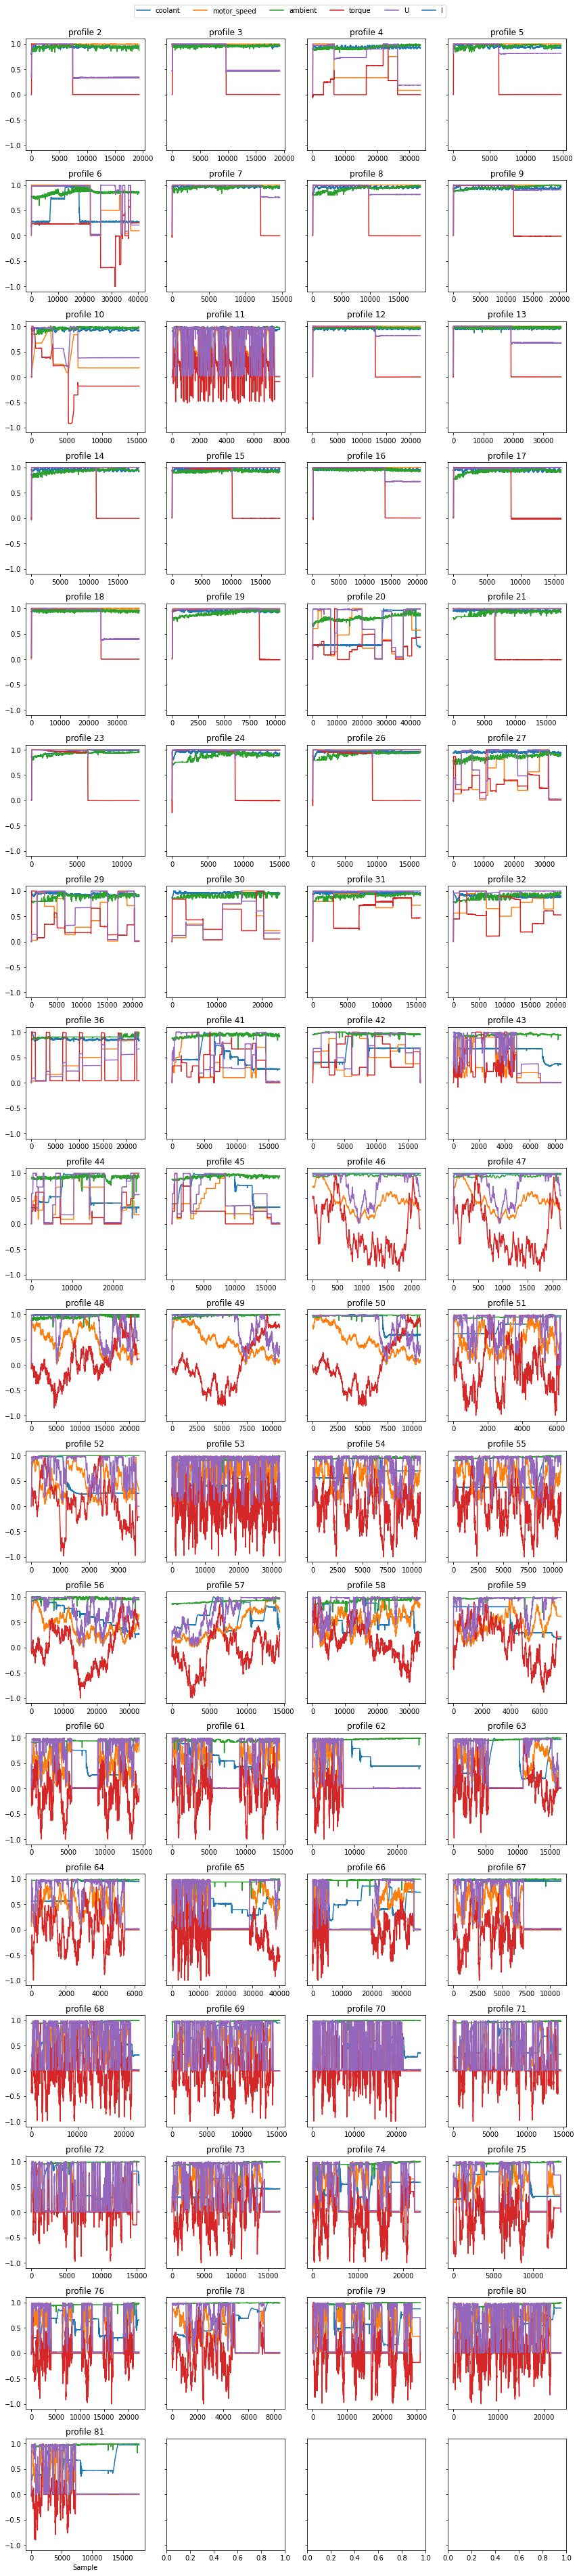

In [ ]:
inputVar = pd.DataFrame(['coolant', 'motor_speed', 'ambient', 'torque', 'U', 'I'])

numOfRows = np.ceil(81 / 4)

fig, axs = plt.subplots(18, 4, figsize=(12,numOfRows*2.5), sharey=True)

j = 0
k = 0

for i in range(0, 84):
  d = measures_df.loc[measures_df['profile_id'] == i]

  if (d.shape[0] > 0):
    axs[k, j].plot(d[inputVar[0][0]].reset_index(drop=True) / d[inputVar[0][0]].reset_index(drop=True).abs().max()) # normalize between 1 and -1
    axs[k, j].plot(d[inputVar[0][1]].reset_index(drop=True) / d[inputVar[0][1]].reset_index(drop=True).abs().max())
    axs[k, j].plot(d[inputVar[0][2]].reset_index(drop=True) / d[inputVar[0][2]].reset_index(drop=True).abs().max())
    axs[k, j].plot(d[inputVar[0][3]].reset_index(drop=True) / d[inputVar[0][3]].reset_index(drop=True).abs().max())
    axs[k, j].plot(d[inputVar[0][4]].reset_index(drop=True) / d[inputVar[0][4]].reset_index(drop=True).abs().max())
    axs[k, j].set_title(f'profile {i}')

    if j == 0:
      axs[k, j].set_ylabel('')
    if i > 80:
      axs[k, j].set_xlabel('Sample')

    if j == 3:
      j = 0
      k += 1
    else:
      j += 1

fig.tight_layout()

fig.legend(labels=['coolant', 'motor_speed', 'ambient', 'torque', 'U', 'I'], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

fig.show()

## Remove Outliers

In [ ]:
v = measures_df.values
mask = np.abs((v - v.mean(0)) / v.std(0)) > 2 
new_measures_df = pd.DataFrame(np.where(mask, np.nan, v), measures_df.index, measures_df.columns)

new_measures_df.isna().sum()

clean_measures_df = new_measures_df.dropna()
clean_measures_df.shape

(1049259, 11)

## Apply EWMA

In [ ]:
save = measures_df

In [ ]:
measures_df = save.ewm(span=5, adjust=False).mean()
clean_measures_df = save.ewm(span=5, adjust=False).mean()
measures_df_2 = save.ewm(span=60, adjust=False).mean()
measures_df_3 = save.ewm(span=20, adjust=False).mean()

Text(0.5, 1.0, 'EWMA Comparison')

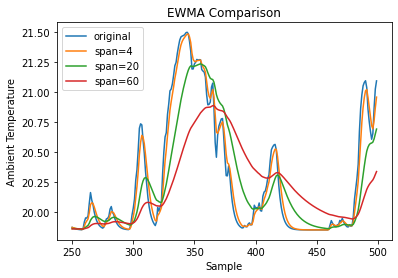

In [ ]:
save['ambient'].iloc[250:500].plot()
measures_df['ambient'].iloc[250:500].plot()
measures_df_3['ambient'].iloc[250:500].plot()
measures_df_2['ambient'].iloc[250:500].plot()

plt.legend(labels=['original', 'span=4', 'span=20', 'span=60'])
plt.xlabel('Sample')
plt.ylabel('Ambient Temperature')
plt.title('EWMA Comparison')

## Splitting and Normalization

### Normal Splitting

Split the `clean_measures_df` and `measures_df` into proper training and testing splits as well as normalize both dataframes

In [ ]:
#Extracting Input and Output variables
x = measures_df[['coolant', 'motor_speed', 'ambient', 'torque', 'U', 'I']]
y = measures_df[['stator_winding', 'stator_tooth', 'stator_yoke', 'pm']]

clean_x = clean_measures_df[['coolant', 'motor_speed', 'ambient', 'torque', 'U', 'I']]
clean_y = clean_measures_df[['stator_winding', 'stator_tooth', 'stator_yoke', 'pm']]

In [ ]:
#for regular
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
clean_x_train, clean_x_test, clean_y_train, clean_y_test = train_test_split(clean_x, clean_y, test_size = 0.3, random_state = 0) 

###Sequential Splitting

In [ ]:
# multivariate one step problem
from numpy import hstack
from numpy import insert
from numpy import append
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# define dataset for RAW
coolant_seq = np.array(measures_df['coolant'])
motor_speed_seq = np.array(measures_df['motor_speed'])
ambient_seq = np.array(measures_df['ambient'])
torque_seq = np.array(measures_df['torque'])
U_seq = np.array(measures_df['U'])
I_seq = np.array(measures_df['I'])

stator_winding_seq = np.array(measures_df['stator_winding'])
stator_tooth_seq = np.array(measures_df['stator_tooth'])
stator_yoke_seq = np.array(measures_df['stator_yoke'])
pm_seq = np.array(measures_df['pm'])

In [ ]:
# define dataset for CLEAN
coolant_seq = np.array(clean_measures_df['coolant'])
motor_speed_seq = np.array(clean_measures_df['motor_speed'])
ambient_seq = np.array(clean_measures_df['ambient'])
torque_seq = np.array(clean_measures_df['torque'])
U_seq = np.array(clean_measures_df['U'])
I_seq = np.array(clean_measures_df['I'])

stator_winding_seq = np.array(clean_measures_df['stator_winding'])
stator_tooth_seq = np.array(clean_measures_df['stator_tooth'])
stator_yoke_seq = np.array(clean_measures_df['stator_yoke'])
pm_seq = np.array(clean_measures_df['pm'])

In [ ]:
# reshape series
coolant_seq = append(coolant_seq, 0)
motor_speed_seq = append(motor_speed_seq, 0)
ambient_seq = append(ambient_seq, 0)
torque_seq = append(torque_seq, 0)
U_seq = append(U_seq, 0)
I_seq = append(I_seq, 0)

coolant_seq = coolant_seq.reshape((len(coolant_seq), 1))
motor_speed_seq = motor_speed_seq.reshape((len(motor_speed_seq), 1))
ambient_seq = ambient_seq.reshape((len(ambient_seq), 1))
torque_seq = torque_seq.reshape((len(torque_seq), 1))
U_seq = U_seq.reshape((len(U_seq), 1))
I_seq = I_seq.reshape((len(I_seq), 1))

# horizontally stack columns
in_dataset = hstack((coolant_seq, motor_speed_seq, ambient_seq, torque_seq, U_seq, I_seq))

In [ ]:
# shift the target sample by one step
stator_winding_seq = insert(stator_winding_seq, 0, 0)
stator_tooth_seq = insert(stator_tooth_seq, 0, 0)
stator_yoke_seq = insert(stator_yoke_seq, 0, 0)
pm_seq = insert(pm_seq, 0, 0)

stator_winding_seq = stator_winding_seq.reshape((len(stator_winding_seq), 1))
stator_tooth_seq = stator_tooth_seq.reshape((len(stator_tooth_seq), 1))
stator_yoke_seq = stator_yoke_seq.reshape((len(stator_yoke_seq), 1))
pm_seq = pm_seq.reshape((len(pm_seq), 1))

out_dataset = hstack((stator_winding_seq, stator_tooth_seq, stator_yoke_seq, pm_seq))

In [ ]:
# define generator
n_input = 1
generator = TimeseriesGenerator(in_dataset, out_dataset, length=n_input, batch_size=1)

X_gen = []
y_gen = []

# print each sample
for i in range(len(generator)):
  j, k = generator[i]
  X_gen.append(j)
  y_gen.append(k)

X_gen = np.array(X_gen)
y_gen = np.array(y_gen)

In [ ]:
#for sequencing
x_train, x_test, y_train, y_test = train_test_split(X_gen, y_gen, test_size = 0.3, random_state = 0)
clean_x_train, clean_x_test, clean_y_train, clean_y_test = train_test_split(X_gen, y_gen, test_size = 0.3, random_state = 0)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2]*x_train.shape[3])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2]*x_test.shape[3])
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1]*y_train.shape[2])
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1]*y_test.shape[2])

clean_x_train = clean_x_train.reshape(clean_x_train.shape[0], clean_x_train.shape[1]*clean_x_train.shape[2]*clean_x_train.shape[3])
clean_x_test = clean_x_test.reshape(clean_x_test.shape[0], clean_x_test.shape[1]*clean_x_test.shape[2]*clean_x_test.shape[3])
clean_y_train = clean_y_train.reshape(clean_y_train.shape[0], clean_y_train.shape[1]*clean_y_train.shape[2])
clean_y_test = clean_y_test.reshape(clean_y_test.shape[0], clean_y_test.shape[1]*clean_y_test.shape[2])

###Data Normalization

**Normalization of our data, explaination in full provided in the report**\
The general gist is that because our x values vary in size because of the diff. attrib. we should norm. to [0, 1]

In [ ]:
x_train = preprocessing.minmax_scale(x_train)
x_test = preprocessing.minmax_scale(x_test)

clean_x_train = preprocessing.minmax_scale(clean_x_train)
clean_x_test = preprocessing.minmax_scale(clean_x_test)

print(x_train, x_test)

[[0.05740402 0.07441343 0.55923238 0.48533511 0.09076955 0.00630768]
 [0.22556304 0.96062595 0.74932437 0.48630263 0.92542259 0.32878859]
 [0.05376563 0.27562687 0.36310111 0.68821962 0.67476765 0.38609681]
 ...
 [0.50602635 0.20983891 0.84469475 0.21272761 0.48264643 0.51398437]
 [0.05897323 0.35611173 0.60279662 0.48420317 0.70945764 0.00630875]
 [0.05000253 0.03417124 0.71412613 0.49603296 0.01370687 0.00630933]] [[0.05666308 0.79723098 0.39454026 0.63257892 0.97781424 0.56273285]
 [0.57393363 0.02677022 0.63458067 0.48478139 0.00669889 0.00630901]
 [0.23716242 0.02672909 0.55493349 0.48478141 0.01167744 0.00630976]
 ...
 [0.06165369 0.14838654 0.6536297  0.75976129 0.38461998 0.51218288]
 [0.04852502 0.51266488 0.57013389 0.59179083 0.98315468 0.24714406]
 [0.44718896 0.82935583 0.66723755 0.59533677 0.97280867 0.44118057]]


In [ ]:
x_train = clean_x_train
x_test = clean_x_test
y_train = clean_y_train
y_test = clean_y_test

# K-Nearest Neighbour Model

## Hyperparameter Tuning

Determine the optimal `n_neighbors`

In [ ]:
from sklearn import metrics

mean_r2 = [0]
mean_mse = [0]
mean_mae = [0]
j=1
for i in range(1,41):
    #Train Model and Predict  
    knn = KNeighborsRegressor(n_neighbors = i, p=1, metric='minkowski').fit(x_train, y_train)
    pred= knn.predict(x_test)
    mean_r2.append(r2_score(y_test, pred))
    mean_mse.append(mean_absolute_error(y_test, pred))
    mean_mae.append(mean_squared_error(y_test, pred))
    j+=1

mean_r2_df = pd.DataFrame(mean_r2)
mean_mse_df = pd.DataFrame(mean_mse)
mean_mae_df = pd.DataFrame(mean_mae)

print(mean_r2, mean_mse, mean_mae)

[0, 0.925730454528937, 0.9408497277931823, 0.9449401936649823, 0.9452717429038118, 0.9462366398188022, 0.9455491308372166, 0.9449462425790931, 0.9451364771678226, 0.9448404995030577, 0.9444218635786757, 0.9443239116216949, 0.9441824811598564, 0.9438832844856215, 0.9435530037984827, 0.9431797804660504, 0.942819177593706, 0.9424045778201651, 0.942035160893061, 0.941599952018234, 0.9412300418238986, 0.9408326410441687, 0.9403955718810852, 0.9400140521991123, 0.9396212943469362, 0.9392488251660495, 0.9388906161823835, 0.938542544062438, 0.938166118136186, 0.9377978472460475, 0.9374037765900053, 0.9370613427769818, 0.936693335288499, 0.9363699151135323, 0.9360166761795624, 0.935676430015675, 0.9353251405964299, 0.9350079942775348, 0.9346860365701842, 0.9343687864507753, 0.9340521940541243] [0, 2.2121605716329693, 2.1579399366423866, 2.1925249811938348, 2.2612522325073536, 2.2999402473358264, 2.354015557403991, 2.4019465160495725, 2.434100714783796, 2.468466836344052, 2.5006214467248773, 2.5

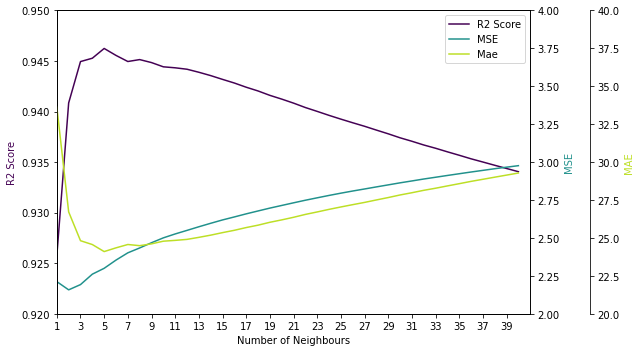

In [ ]:
ticks = np.arange(1,len(mean_r2),step=2.0)

fig, ax = plt.subplots(figsize=(9,5)) # (width, height) in inches
    
mse = ax.twinx()
mae = ax.twinx()
    
ax.set_xlim(1, len(mean_r2))
ax.set_ylim(0.92, 0.95)
mse.set_ylim(2, 4)
mae.set_ylim(20, 40)
    
ax.set_xlabel("Number of Neighbours")
ax.set_ylabel("R2 Score")
mse.set_ylabel("MSE")
mae.set_ylabel("MAE")

color1 = plt.cm.viridis(0)
color2 = plt.cm.viridis(0.5) #get diff colours
color3 = plt.cm.viridis(.9)

p1, = ax.plot(mean_r2_df,    color=color1, label="R2 Score")
p2, = mse.plot(mean_mse_df,    color=color2, label="MSE")
p3, = mae.plot(mean_mae_df, color=color3, label="Mae")

lns = [p1, p2, p3]
ax.legend(handles=lns, loc='best')

# right, left, top, bottom
mae.spines['right'].set_position(('outward', 60))
                 
mae.xaxis.set_ticks(ticks)

ax.yaxis.label.set_color(p1.get_color())
mse.yaxis.label.set_color(p2.get_color())
mae.yaxis.label.set_color(p3.get_color())

fig.tight_layout()

Create the model to fit

In [ ]:
knn_param = KNeighborsRegressor()

Create a list of dictionaries for the Grid Search

In [ ]:
params = {'n_neighbors' : [1, 2, 3, 4 , 5, 6],
              'p' : [1, 2], 
              'metric' : ['euclidean', 'minkowski', 'manhattan']}

Perform the Grid Search

In [ ]:
search = GridSearchCV(knn_param, params, verbose=1, cv=2)

Fit the data

In [ ]:
result = search.fit(x_train, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


Print the best parameters

In [ ]:
result.best_params_

{'metric': 'minkowski', 'n_neighbors': 2, 'p': 1}

## Implementation

Create model

In [ ]:
knn = KNeighborsRegressor(n_neighbors=2, p=1, metric='minkowski')
knn.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=2, p=1)

Test the accuracy of the model for the training and testing sets

In [ ]:
knn_train_acc = (knn.score(x_train, y_train)) * 100
knn_test_acc = (knn.score(x_test, y_test)) * 100

print("Train Accuracy: ", knn_train_acc)
print("Test Accuracy: ", knn_test_acc)

Train Accuracy:  99.48990452368025
Test Accuracy:  97.51549963971291


Predict the test values

In [ ]:
knn_test_pred = knn.predict(x_test)

Compute the R2 Score, MSE and MAE for the test data

In [ ]:
knn_r2 = r2_score(y_test, knn_test_pred)
knn_mae = mean_absolute_error(y_test, knn_test_pred)
knn_mse = mean_squared_error(y_test, knn_test_pred)

print("R2 Score: ", knn_r2)
print("MAE: ", knn_mae)
print("MSE: ", knn_mse)

R2 Score:  0.9751549963971291
MAE:  1.2998982009795035
MSE:  13.920346643479501


Make predictions

In [ ]:
predictions = pd.DataFrame(np.c_[y_test, knn_test_pred], columns = ["Original stator_winding", "Original stator_tooth", "Original stator_yoke", "Original pm", "Predicted stator_winding", "Predicted stator_tooth", "Predicted stator_yoke", "Predicted pm"])
predictions.head(5)

,Original stator_winding,Original stator_tooth,Original stator_yoke,Original pm,Predicted stator_winding,Predicted stator_tooth,Predicted stator_yoke,Predicted pm
0,66.295602,46.031701,33.113540,39.936611,65.675097,45.985985,32.977648,39.726817
1,85.222973,76.394297,67.218546,72.524501,84.675098,76.079672,67.206439,72.460476
2,48.786769,45.388745,39.495407,43.034084,50.997675,45.990914,42.752849,43.164763
3,104.791174,90.336741,72.127647,74.914005,104.791174,90.693175,73.286836,74.525416
4,113.223181,84.107584,57.476536,89.902986,112.969543,84.146624,57.492409,89.921594


Display a visualization of all the predictions compared with the original temperature

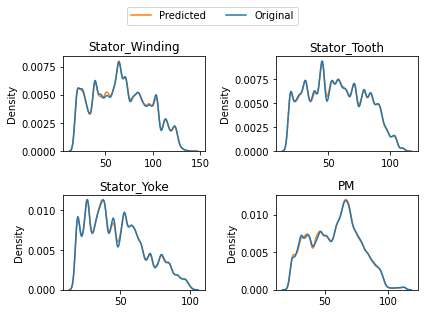

In [ ]:
fig, axs = plt.subplots(2, 2)
sns.kdeplot(ax=axs[0, 0], data=predictions[['Original stator_winding', 'Predicted stator_winding']], legend=False)
axs[0, 0].set_title('Stator_Winding')
sns.kdeplot(ax=axs[0, 1], data=predictions[['Original stator_tooth', 'Predicted stator_tooth']], legend=False)
axs[0, 1].set_title('Stator_Tooth')
sns.kdeplot(ax=axs[1, 0], data=predictions[['Original stator_yoke', 'Predicted stator_yoke']], legend=False)
axs[1, 0].set_title('Stator_Yoke')
sns.kdeplot(ax=axs[1, 1], data=predictions[['Original pm', 'Predicted pm']], legend=False)
axs[1, 1].set_title('PM')

plt.tight_layout()

plt.legend(labels=["Predicted", "Original"], ncol=15, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)

plt.show()